# Using K-Nearest Neighbor to Classify Data Point Risk Level

## Set Up

Import the required libraries and the dataset.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap

warnings.filterwarnings('ignore')

df = pd.read_csv("../datasets/_integrated-data/processed-monthly-genderless.csv")

# Count of number of pollutant features in the dataset
column_list = ['CO ppm', 'NO pphm', 'NO2 pphm', 'OZONE pphm', 'PM10 µg/m³', 'SO2 pphm']
n_pollutants = sum([1 for col in df.columns if col in column_list])

# Efeaturetract pollutant columns and columns after the pollutants
pollutant_columns = [col for col in df.columns if col in column_list]
health_stat_columns = df.iloc[:, df.columns.get_loc(pollutant_columns[-1]) + 1:]

# Show the dataset
print(f"Dataset shape: {df.shape}")
print(f"Number of pollutant features: {n_pollutants}")
df.describe()

Dataset shape: (1560, 9)
Number of pollutant features: 6


,CO ppm,NO pphm,NO2 pphm,OZONE pphm,PM10 µg/m³,SO2 pphm,asthma edp
count,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000,1560.000000
mean,0.133039,0.547513,0.585202,1.854216,18.511935,0.068814,30.154487
std,0.076290,0.732098,0.374287,0.431311,4.919421,0.047696,13.902653
min,0.000000,0.000000,0.000000,0.623026,8.095566,0.000000,3.600000
25%,0.100000,0.136131,0.302769,1.550000,15.605194,0.033193,20.100000
50%,0.133039,0.275000,0.484458,1.850000,18.511935,0.068814,28.000000
75%,0.193861,0.575000,0.755558,2.150000,19.680863,0.100000,38.300000
max,0.456505,4.576080,2.072091,3.213516,45.265611,0.252773,91.700000


## Model Training Preparation

Prepare the dataframe for training.

year-month                 2014-07
lhd                  Central Coast
asthma edp                     3.6
pollution score                0.0
health risk score              0.0
risk level                Low Risk
dtype: object

year-month                  2024-06
lhd                  Western Sydney
asthma edp                     91.7
pollution score                 1.0
health risk score               1.0
risk level                High Risk
dtype: object

,asthma edp,pollution score,health risk score
count,1560.000000,1560.000000,1560.000000
mean,30.154487,0.364902,0.635098
std,13.902653,0.158096,0.158096
min,3.600000,0.000000,0.000000
25%,20.100000,0.251896,0.558985
50%,28.000000,0.348507,0.651493
75%,38.300000,0.441015,0.748104
max,91.700000,1.000000,1.000000


,year-month,lhd,asthma edp,pollution score,health risk score,risk level
0,2014-07,Central Coast,26.1,0.174976,0.825024,High Risk
1,2014-08,Central Coast,33.4,0.195944,0.804056,High Risk
2,2014-09,Central Coast,24.1,0.206016,0.793984,High Risk
3,2014-10,Central Coast,24.0,0.409627,0.590373,Medium Risk
4,2014-11,Central Coast,25.0,0.385099,0.614901,Medium Risk
...,...,...,...,...,...,...
1555,2024-02,Western Sydney,16.8,0.351217,0.648783,Medium Risk
1556,2024-03,Western Sydney,16.8,0.393210,0.606790,Medium Risk
1557,2024-04,Western Sydney,16.8,0.395803,0.604197,Medium Risk
1558,2024-05,Western Sydney,16.8,0.436884,0.563116,Medium Risk


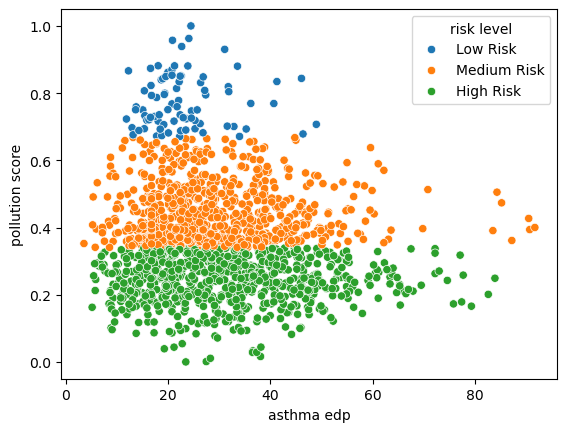

In [2]:
# Scale then combine pollutant values into a single pollution score. Scale this score to 0-1
scaler = MinMaxScaler()
df[pollutant_columns] = scaler.fit_transform(df[pollutant_columns])
df['pollution score'] = scaler.fit_transform(df[pollutant_columns].sum(axis=1).values.reshape(-1, 1))
df = df.drop(pollutant_columns, axis=1)
df

# Calculate the correlation between 'asthma edp' and 'pollution score'
correlation = df['asthma edp'].corr(df['pollution score'])

# Multiply the correlation by the pollution score to determine it's health risk score
df['health risk score'] = df['pollution score'] * correlation
df['health risk score'] = scaler.fit_transform(df['health risk score'].values.reshape(-1, 1))

bins = [-0.1, 0.33, 0.66, 1]
labels = ['Low Risk', 'Medium Risk', 'High Risk']

# Categorize the 'health risk score' based on the thresholds
df['risk level'] = pd.cut(df['health risk score'], bins=bins, labels=labels)


# dispay asthma vs. pollution score
display(df.min(),df.max(),df.describe(),df)
sns.scatterplot(x=df['asthma edp'],y=df['pollution score'], hue=df['risk level'])
plt.show()


## Model Training

- Split the data up into features and targets, and into training/test sets.
- Scale the features for the training and testing sets.
- Determine the optimal k-value for training.

KNeighborsClassifier(n_neighbors=13)

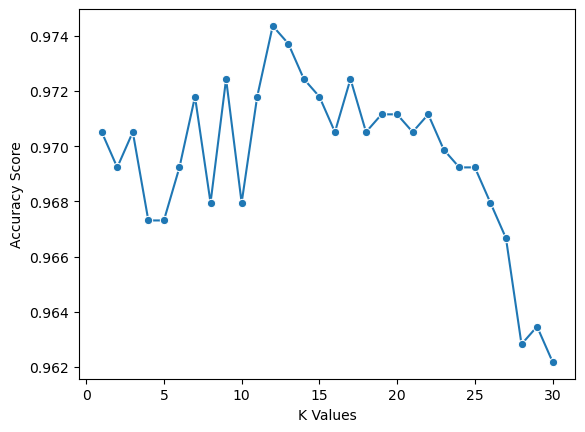

In [3]:
# Split the data into features (X) and target (y)
X = df.drop(['year-month','lhd','health risk score','risk level'], axis=1)
y = df['risk level']

## Map the risk levels to numbers for plotting
risk_mapping = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
y_numeric = y.map(risk_mapping)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2)

# Scale the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Determine the best K Value
k_values = [i for i in range (1,31)]
scores = []
scaler = StandardScaler()
X = scaler.fit_transform(X)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X, y, cv=5)
    scores.append(np.mean(score))

# Plot the K-values.
sns.lineplot(x = k_values, y = scores, marker = 'o')
plt.xlabel("K Values")
plt.ylabel("Accuracy Score")

# Train the K-NN model
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(X_train, y_train)

## Model Testing

Use the model to predict based on test data.

In [4]:
# Make predictions
y_pred = knn.predict(X_test)

## Model Performance

- Print the models performance metrics
- Generate and display the confusion matrix.
- Generate and display the decision boundaries.

Accuracy: 0.9583333333333334
              precision    recall  f1-score   support

    Low Risk       1.00      0.73      0.85        15
 Medium Risk       0.95      0.96      0.96       144
   High Risk       0.96      0.98      0.97       153

    accuracy                           0.96       312
   macro avg       0.97      0.89      0.92       312
weighted avg       0.96      0.96      0.96       312



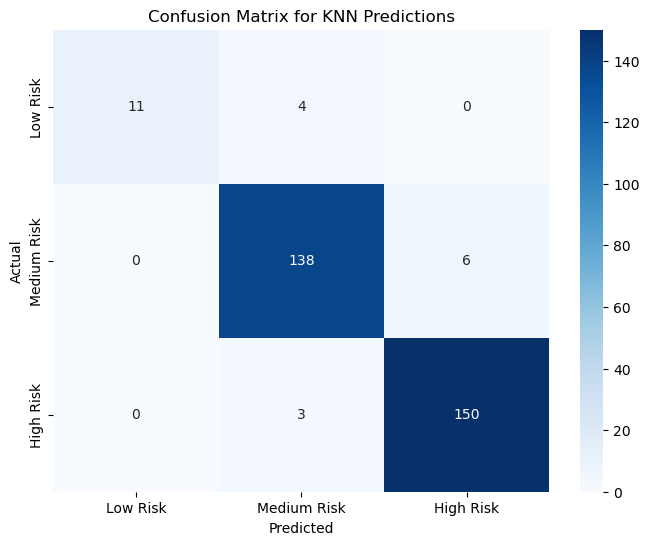

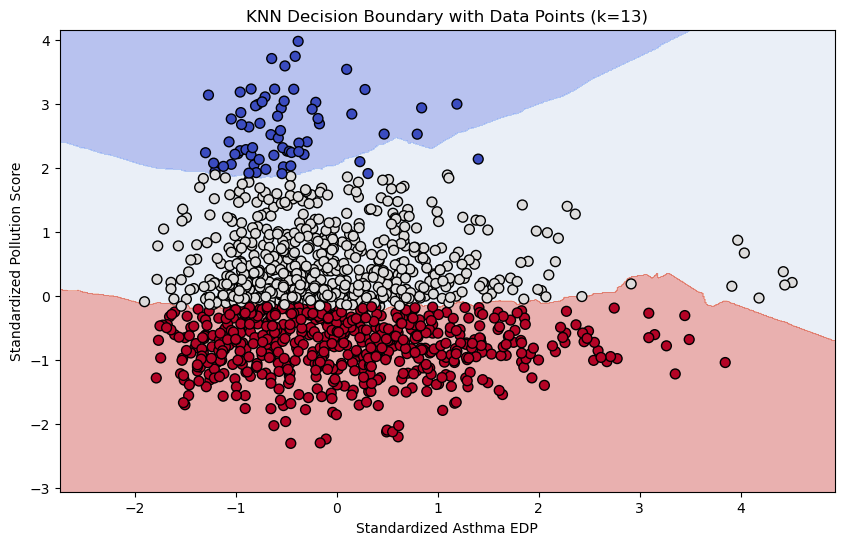

In [5]:

# print performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, target_names=labels))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Predictions')
plt.show()


# Create a mesh grid for plotting decision boundary
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict for each point in the mesh grid
Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(10, 6))

# Plot the decision boundary with contourf
plt.contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')

# Overlay the training data points with a scatter plot
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=y_train, cmap='coolwarm', edgecolor='k', s=50)

# Label axes and title
plt.xlabel('Standardized Asthma EDP')
plt.ylabel('Standardized Pollution Score')
plt.title('KNN Decision Boundary with Data Points (k=13)')

# Show the plot
plt.show()